<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.DigitRecognizer/blob/resnet/0_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Stretch tasks:
    - Create a baseline with Batch Normalization, without looking on the Internet
    - (Done) Create a baseline with Dropout, without looking on the Internet
    - Implement classic architectures (AlexNet, VGG), without looking
    - (Done) Implement model checkpoint callbacks (save every epoch)
    - Write NN with functional API, not looking on the Internet
    - (Done) Enwrap your FFNN for grid search CV and find the best architecture
    - Stretch pants approach
    - Correct initialization strategies for different activation functions
    - (Done) Use functools.partial in building sequential model
    - (Done) Transfer learning

# Imports

In [1]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import preprocess_input as \
    resnet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint

## Pep 8 standard

In [2]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

## Custom packages

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager
from sklearn_utils import (
    nan_statistics,
    visualize_datasets_distributions
)

In [5]:
def plot_history(history_):
    _, ax = plt.subplots(1, 2, figsize=(8, 3))

    ax[0].plot(
        history.history['loss'],
        label='loss'
    )
    ax[0].plot(
        history.history['val_loss'],
        label='val_loss'
    )

    ax[0].legend()

    ax[1].plot(
        history.history['accuracy'],
        label='acc'
    )
    ax[1].plot(
        history.history['val_accuracy'],
        label='val_acc'
    )
    ax[1].legend()

# Helper functions

In [6]:
def prepare_resnet_data(arr_):
    print(f'Init shape: {arr_.shape}')
    arr_images = arr_.reshape(arr_.shape[0], 28, 28)
    print(f'Init shape: {arr_images.shape}')
    arr_images_with_color_channel = np.stack(
        [arr_images, arr_images, arr_images],
        axis=-1
    )
    output = resnet_preprocess(
        arr_images_with_color_channel,
        data_format='channels_last'
    )
    del arr_images
    del arr_images_with_color_channel
    print(f'Result: {output.shape, report([output])}')
    print()
    return output

In [7]:
def reshape(arr):
    return arr.reshape(arr.shape[0], 28, 28)

In [8]:
def print_shapes(arrs_):
    for arr_ in arrs_:
        print(arr_.shape)

In [9]:
def report(arrs_):
    for arr_ in arrs_:
        print(np.max(arr_), np.min(arr_))

In [10]:
def get_X_Y(df_):
    assert 'label' in df_.columns
    Y = df_['label'].values
    df_dropped = df_.drop(['label'], axis='columns')
    X = df_dropped.values
    del df_dropped
    return X, Y

In [11]:
def get_subsample(percentage):
    
    X_train_subsample, _, Y_train_subsample, _ = train_test_split(
        X_train,
        Y_train,
        train_size=percentage,  # 0.8,
        random_state=RANDOM_STATE,
        stratify=Y_train
    )

    X_validation_subsample, _, Y_validation_subsample, _ = \
        train_test_split(
            X_validation,
            Y_validation,
            train_size=percentage,  # 0.1,
            random_state=RANDOM_STATE,
            stratify=Y_validation
    )
    
    return {
        "train": (X_train_subsample, Y_train_subsample),
        "validation": (X_validation_subsample, Y_validation_subsample)
    }

# Setup paths

In [12]:
drive.mount('/content/gdrive', force_remount=True)  # force_remount=True
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 'ResNet_transfer_learning'
MODELS_TRIAL = 'baseline'
COMPETITION_PATH = gdrive_path + 'ML/Competitions/3.DigitRecognizer/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/3.DigitRecognizer/Data/preproc_trial_ResNet_transfer_learning already exists
/content/gdrive/MyDrive/ML/Competitions/3.DigitRecognizer/Models/trial_baseline already exists


# Download the data

In [13]:
df_total = pd.read_csv(manager.train_path)
df_total.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_test = pd.read_csv(manager.test_path)
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Quick data exporation

## Nan values

In [ ]:
assert not df_train.isna().any().any()
assert not df_test.isna().any().any()

In [ ]:
import numpy as np
print(np.max(df_train.values), np.min(df_train.values))
print(np.max(df_test.values), np.min(df_test.values))

255 0
255 0


## Class balance

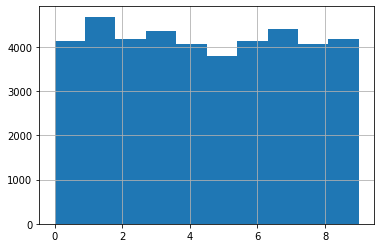

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
df_train['label'].hist(ax=ax)

# Create train, validation and test sets

In [15]:
from sklearn.model_selection import train_test_split

TRAINVAL_SIZE = 0.99
RANDOM_STATE = 42

# df_trainval, df_test_sample = train_test_split(
#     total,
#     train_size=TRAINVAL_SIZE,
#     random_state=RANDOM_STATE,
#     stratify=df_train['label']
# )
# df_trainval.shape, df_test.shape

In [16]:
TRAIN_SIZE = 0.8

df_train, df_validation = train_test_split(
    df_total,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_total['label']
)
df_train.shape, df_validation.shape

((33600, 785), (8400, 785))

# Data exploration (from now on, on train set)

In [ ]:
vals = df_train.values[0, 1:]
type(vals)

numpy.ndarray

(-0.5, 27.5, 27.5, -0.5)

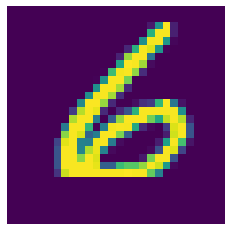

In [ ]:
plt.imshow(vals.reshape(28, 28))
plt.axis('off')

# Data preparation

- Standardize the data
- Transform Y into vector form

In [17]:
X_train, Y_train = get_X_Y(df_train)
X_validation, Y_validation = get_X_Y(df_validation)

In [18]:
Y_train.shape, X_train.shape

((33600,), (33600, 784))

In [19]:
# X_test_sample, Y_test_sample = get_X_Y(df_test_sample)

In [20]:
X_test = df_test.values

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()
standardizer = StandardScaler()

In [23]:
X_train = X_train / 255.0  # scaler.fit_transform(X_train)
X_validation = X_validation / 255.0  # scaler.transform(X_validation)
# X_test_sample = X_test_sample / 255.0  # scaler.transform(X_test_sample)
X_test = X_test / 255.0  # scaler.transform(X_test)

In [24]:
report([X_train, X_validation, X_test])

1.0 0.0
1.0 0.0
1.0 0.0


In [25]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
Y_train = enc.fit_transform(np.array(Y_train).reshape(-1, 1)).toarray()
Y_validation = enc.transform(np.array(Y_validation).reshape(-1, 1)).toarray()
# Y_test_sample = enc.transform(np.array(Y_test_sample).reshape(-1, 1)).toarray()

In [26]:
Y_train.shape

(33600, 10)

In [27]:
X_train.shape, X_validation.shape, Y_train.shape

((33600, 784), (8400, 784), (33600, 10))

In [28]:
res = get_subsample(0.3)

X_train_subsample, Y_train_subsample = res['train']
X_validation_subsample, Y_validation_subsample = res['validation']

X_train_subsample.shape, Y_train_subsample.shape, \
X_validation_subsample.shape, Y_validation_subsample.shape, \
X_train.shape

((10080, 784), (10080, 10), (2520, 784), (2520, 10), (33600, 784))

In [29]:
report([X_train_subsample, X_validation_subsample])

1.0 0.0
1.0 0.0


# Save data

In [ ]:
# manager.save_to_csv(
#     df_train,
#     manager.data_trial_path,
#     'train_processed.csv'
# )

# manager.save_to_csv(
#     df_val,
#     manager.data_trial_path,
#     'val_processed.csv'
# )

In [ ]:
# manager.save_to_csv(
#     df_test_sample,
#     manager.data_trial_path,
#     'test_sample_processed.csv'
# )

In [ ]:
# manager.save_to_csv(
#     df_test,
#     manager.data_trial_path,
#     'test_processed.csv'
# )

# Model preparation

## Sequential baseline

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from functools import partial
import tensorflow

dense_layer = partial(
    Dense,
    activation='relu',
    kernel_initializer=tensorflow.keras.initializers.HeNormal()
)

ffnn_baseline = Sequential(
    [
        Input(shape=(784,)),
        dense_layer(units=784),
        dense_layer(units=300),
        dense_layer(units=300),
        dense_layer(units=300),
        Dropout(0.4),
        Dense(units=10, activation='softmax')
    ]
)

In [ ]:
ffnn_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
X_train.shape, Y_train.shape

((26880, 784), (26880, 10))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
history = ffnn_baseline.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    batch_size=32,
    epochs=50,
    callbacks=[EarlyStopping(patience=2)]
)

Epoch 1/50
840/840 [==============================] - 14s 15ms/step - loss: 0.3727 - accuracy: 0.8953 - val_loss: 0.2126 - val_accuracy: 0.9397
Epoch 2/50
840/840 [==============================] - 14s 16ms/step - loss: 0.1776 - accuracy: 0.9511 - val_loss: 0.2225 - val_accuracy: 0.9408
Epoch 3/50
840/840 [==============================] - 14s 16ms/step - loss: 0.1383 - accuracy: 0.9619 - val_loss: 0.1803 - val_accuracy: 0.9563
Epoch 4/50
840/840 [==============================] - 13s 15ms/step - loss: 0.1144 - accuracy: 0.9692 - val_loss: 0.1699 - val_accuracy: 0.9567
Epoch 5/50
840/840 [==============================] - 13s 15ms/step - loss: 0.0958 - accuracy: 0.9725 - val_loss: 0.2189 - val_accuracy: 0.9497
Epoch 6/50
840/840 [==============================] - 15s 18ms/step - loss: 0.0948 - accuracy: 0.9763 - val_loss: 0.2176 - val_accuracy: 0.9513


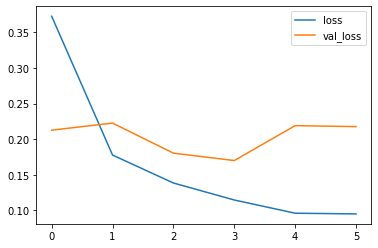

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()

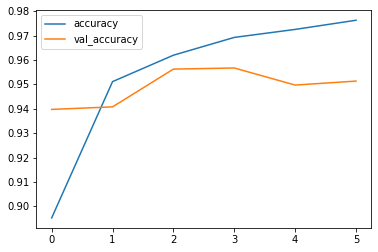

In [ ]:
_, ax = plt.subplots()
ax.plot(history.history['accuracy'], label='accuracy')
ax.plot(history.history['val_accuracy'], label='val_accuracy')
ax.legend()

## Enwrap FFNN into grid search CV

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def build_model(
    n_hidden_layers_=3,
    dropout_rate_=0.3,
    width_=100,
    activation_='relu',
    learning_rate_=0.0001
):
    model = Sequential()
    model.add(Input(shape=(784,)))
    model.add(Dense(28 * 28, activation=activation_))

    for _ in range(n_hidden_layers_ - 2):
        model.add(Dense(units=width_, activation=activation_))
    
    model.add(Dropout(dropout_rate_))

    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate_),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
keras_reg = KerasRegressor(build_model)

<ipython-input-106-e1ebe08fc635>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_model)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal


In [ ]:
estimator = RandomizedSearchCV(
    keras_reg,
    {
        'n_hidden_layers_': list(range(2, 5)),
        'dropout_rate_': [0.2, 0.3, 0.4, 0.5],
        # 'learning_rate_': [0.001, 0.0001, 0.0015],
        'learning_rate_': [3e-4, 3e-2],
        'width_': [200, 300, 350, 400,]
    },
    cv=4,
    n_iter=3
)

In [ ]:
res = estimator.fit(
    X_train_subsample,
    Y_train_subsample,
    epochs=20,
    validation_data=(X_validation_subsample, Y_validation_subsample),
    batch_size=32,
    callbacks=[EarlyStopping(patience=2, mode='min', monitor='val_accuracy')]
)

Epoch 1/20
315/315 [==============================] - 5s 15ms/step - loss: 0.6974 - accuracy: 0.8039 - val_loss: 0.3650 - val_accuracy: 0.9000
Epoch 2/20
315/315 [==============================] - 4s 13ms/step - loss: 0.2532 - accuracy: 0.9258 - val_loss: 0.2947 - val_accuracy: 0.9164
Epoch 3/20
105/105 [==============================] - 1s 5ms/step - loss: 0.2300 - accuracy: 0.9354
Epoch 1/20
315/315 [==============================] - 5s 15ms/step - loss: 0.7162 - accuracy: 0.7971 - val_loss: 0.3560 - val_accuracy: 0.9048
Epoch 2/20
315/315 [==============================] - 4s 14ms/step - loss: 0.2575 - accuracy: 0.9236 - val_loss: 0.2756 - val_accuracy: 0.9223
Epoch 3/20
105/105 [==============================] - 1s 5ms/step - loss: 0.2166 - accuracy: 0.9369
Epoch 1/20
315/315 [==============================] - 5s 14ms/step - loss: 0.6881 - accuracy: 0.8041 - val_loss: 0.3820 - val_accuracy: 0.9015
Epoch 2/20
315/315 [==============================] - 4s 14ms/step - loss: 0.2594 - a

In [ ]:
res.best_params_, \
    res.best_score_,

({'width_': 350,
  'n_hidden_layers_': 3,
  'learning_rate_': 0.0001,
  'dropout_rate_': 0.2},
 -0.22469522058963776)

In [ ]:
res.best_estimator_.model

## Baseline CNN

In [ ]:
from functools import partial

conv_layer = partial(
    layers.Conv2D,
    activation='relu',
    kernel_size=(3, 3)
)

baseline_cnn = Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        conv_layer(filters=32), # (5, 5) kernel used to be before
        conv_layer(filters=64),
        layers.MaxPool2D(pool_size=2),
        conv_layer(filters=128),
        
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ]
)

In [ ]:
early_stopper = EarlyStopping(
    patience=2,
    monitor='val_loss',
    mode='min'
)

In [ ]:
baseline_cnn.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam'
)

In [ ]:
history = baseline_cnn.fit(
    X_train.reshape(X_train.shape[0], 28, 28),
    Y_train,
    validation_data=(
        X_validation.reshape(X_validation.shape[0], 28, 28), Y_validation
    ),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopper]
)

Epoch 1/20
 62/840 [=>............................] - ETA: 3:09 - loss: 0.8439 - accuracy: 0.7248

KeyboardInterrupt: ignored

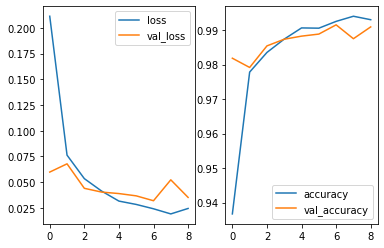

In [ ]:
_, ax = plt.subplots(1, 2)
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].legend()

## Enwrap baseline CNN into randomized search

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.optimizers import Adam

from functools import partial


def build_cnn(
    activation_func_='relu',
    dropout_rate_=0.4,
    learning_rate_=0.001
):

    if activation_func_ == 'relu':
        initializer = 'he_normal'
    if activation_func_ == 'selu':
        initializer = 'lecun_normal'

    conv_layer = partial(
        Conv2D,
        activation=activation_func_,
        kernel_initializer=initializer,
        kernel_size=(3, 3)
    )

    dense_layer = partial(
        Dense,
        activation=activation_func_,
        kernel_initializer=initializer
    )

    # model = Sequential(
    #     [
    #         Input(shape=(28, 28, 1)),
    #         Flatten(),
    #         Dense(10, activation='softmax')
    #     ]
        
    # )

    model = Sequential(
        [
            Input(shape=(28, 28, 1)),
            conv_layer(filters=32),
            conv_layer(filters=64),
            MaxPool2D(pool_size=(2, 2)),

            conv_layer(filters=128),
            Flatten(),
            dense_layer(units=100),
            Dropout(dropout_rate_),
            Dense(units=10, activation='softmax')
        ]
    )

    model.compile(
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        optimizer=Adam(learning_rate=learning_rate_)
    )
    return model

In [ ]:
cnn_builder = tensorflow.keras.wrappers.scikit_learn.KerasRegressor(build_cnn)

<ipython-input-234-90810bec11a3>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn_builder = tensorflow.keras.wrappers.scikit_learn.KerasRegressor(build_cnn)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

cnn_estimator = GridSearchCV(
    cnn_builder,
    {
        'activation_func_': ['selu'],
        'dropout_rate_': [0.4, 0.6],
        'learning_rate_': [0.001, 0.0001]
    },
    cv=2,
    # n_iter=10,
    verbose=3
)

In [ ]:
res = get_subsample(0.6)
X_subsample, Y_subsample = res['train']
X_val_subsample, Y_val_subsample = res['validation']

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping



cnn_res = cnn_estimator.fit(
    reshape(X_subsample),  # reshape(X_train),  # reshape(X_subsample),
    Y_subsample,  # Y_train,  #  Y_subsample,
    # validation_data=(reshape(X_val_subsample), Y_val_subsample),
    validation_data=(reshape(X_validation), Y_validation),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=2, monitor='val_loss', mode='min')
    ]
)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Epoch 1/20
252/252 [==============================] - 43s 166ms/step - loss: 0.5511 - accuracy: 0.8528 - val_loss: 0.1475 - val_accuracy: 0.9555
Epoch 2/20
252/252 [==============================] - 41s 163ms/step - loss: 0.1538 - accuracy: 0.9554 - val_loss: 0.0931 - val_accuracy: 0.9717
Epoch 3/20
252/252 [==============================] - 41s 164ms/step - loss: 0.0948 - accuracy: 0.9701 - val_loss: 0.0765 - val_accuracy: 0.9754
Epoch 4/20
252/252 [==============================] - 43s 172ms/step - loss: 0.0689 - accuracy: 0.9781 - val_loss: 0.0823 - val_accuracy: 0.9781
Epoch 5/20
252/252 [==============================] - 9s 34ms/step - loss: 0.0790 - accuracy: 0.9785
[CV 1/2] END activation_func_=relu, dropout_rate_=0.4, learning_rate_=0.001;, score=-0.079 total time= 4.5min
Epoch 1/20
252/252 [==============================] - 42s 164ms/step - loss: 0.5596 - accuracy: 0.8535 - val_loss: 0.1278 - val_accuracy: 0.9609
Epoc

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def reshape(arr):
    return arr.reshape(arr.shape[0], 28, 28)

cnn_res = cnn_estimator.fit(
    reshape(X_subsample),  # reshape(X_train),  # reshape(X_subsample),
    Y_subsample,  # Y_train,  #  Y_subsample,
    # validation_data=(reshape(X_val_subsample), Y_val_subsample),
    validation_data=(reshape(X_validation), Y_validation),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=2, monitor='val_loss', mode='min')
    ]
)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Epoch 1/20
252/252 [==============================] - ETA: 0s - loss: 0.8204 - accuracy: 0.8473

KeyboardInterrupt: ignored

## Baseline CNN with data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
data_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

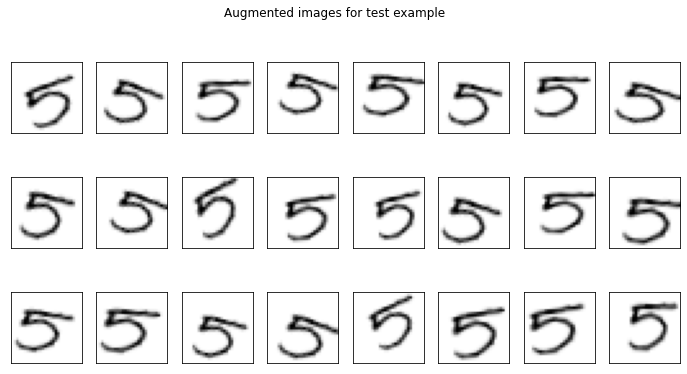

In [ ]:
idx = 10
fig, axes = plt.subplots(3,8, figsize=(12,6))
x = X_train[idx].reshape(-1, 28, 28, 1)
y = Y_train[idx].reshape(-1, 10)

fig.suptitle('Augmented images for test example')
for i in range(3):
    for j in range(8):
        augmented_example_X, augmented_example_y = data_generator.flow(
            x, y, batch_size=1).next()
        axes[i,j].imshow(augmented_example_X.squeeze(), cmap='Greys')
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

In [ ]:
train_generator = data_generator.flow(
    X_train.reshape(X_train.shape[0], 28, 28, 1),
    Y_train,
    batch_size=32
)

In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size
steps_per_epoch

1039

In [ ]:
from functools import partial

conv_layer = partial(
    layers.Conv2D,
    activation='relu',
    kernel_size=(3, 3)
)

baseline_cnn = Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        conv_layer(filters=32), # (5, 5) kernel used to be before
        conv_layer(filters=64),
        layers.MaxPool2D(pool_size=2),
        conv_layer(filters=128),
        conv_layer(filters=128),
        layers.MaxPool2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(300, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ]
)

In [ ]:
baseline_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = baseline_cnn.fit(
    train_generator,
    validation_data=(reshape(X_validation), Y_validation),
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3)]
)

Epoch 1/20
1039/1039 [==============================] - 189s 181ms/step - loss: 0.4213 - accuracy: 0.8650 - val_loss: 0.0527 - val_accuracy: 0.9840
Epoch 2/20
1039/1039 [==============================] - 179s 172ms/step - loss: 0.1360 - accuracy: 0.9593 - val_loss: 0.0430 - val_accuracy: 0.9865
Epoch 3/20
1039/1039 [==============================] - 181s 175ms/step - loss: 0.1043 - accuracy: 0.9693 - val_loss: 0.0409 - val_accuracy: 0.9877
Epoch 4/20
1039/1039 [==============================] - 179s 173ms/step - loss: 0.0831 - accuracy: 0.9759 - val_loss: 0.0396 - val_accuracy: 0.9909
Epoch 5/20
1039/1039 [==============================] - 180s 174ms/step - loss: 0.0772 - accuracy: 0.9779 - val_loss: 0.0481 - val_accuracy: 0.9870
Epoch 6/20
1039/1039 [==============================] - 181s 174ms/step - loss: 0.0755 - accuracy: 0.9776 - val_loss: 0.0331 - val_accuracy: 0.9907
Epoch 7/20
1039/1039 [==============================] - 180s 173ms/step - loss: 0.0685 - accuracy: 0.9813 - val_

## ResNet50

### Preprocess the data

In [ ]:
X_train, Y_train = get_X_Y(df_train)
X_validation, Y_validation = get_X_Y(df_validation)
X_test = df_test.values

res = get_subsample(0.3)
X_train_subsample, Y_train_subsample = res['train']
X_validation_subsample, Y_validation_subsample = res['validation']

arrs = [X_train, X_validation, X_train_subsample, X_validation_subsample, X_test]
report(arrs)
print_shapes(arrs)

255 0
255 0
255 0
255 0
255 0
(33600, 784)
(8400, 784)
(10080, 784)
(2520, 784)
(28000, 784)


In [ ]:
X_train_resnet = prepare_resnet_data(X_train)
X_validation_resnet = prepare_resnet_data(X_validation)
X_train_subsample_resnet = prepare_resnet_data(X_train_subsample)
X_validation_subsample_resnet = prepare_resnet_data(X_validation_subsample)
X_test_resnet = prepare_resnet_data(X_test)

Init shape: (33600, 784)
Init shape: (33600, 28, 28)
151.061 -123.68
Result: ((33600, 28, 28, 3), None)

Init shape: (8400, 784)
Init shape: (8400, 28, 28)
151.061 -123.68
Result: ((8400, 28, 28, 3), None)

Init shape: (10080, 784)
Init shape: (10080, 28, 28)
151.061 -123.68
Result: ((10080, 28, 28, 3), None)

Init shape: (2520, 784)
Init shape: (2520, 28, 28)
151.061 -123.68
Result: ((2520, 28, 28, 3), None)

Init shape: (28000, 784)
Init shape: (28000, 28, 28)
151.061 -123.68
Result: ((28000, 28, 28, 3), None)



In [ ]:
processed_arrs = [
    X_train_resnet,
    X_validation_resnet,
    X_test_resnet,

    X_train_subsample_resnet,
    X_validation_subsample_resnet
]

report(processed_arrs)
print_shapes(processed_arrs)

151.061 -123.68
151.061 -123.68
151.061 -123.68
151.061 -123.68
151.061 -123.68
(33600, 28, 28, 3)
(8400, 28, 28, 3)
(28000, 28, 28, 3)
(10080, 28, 28, 3)
(2520, 28, 28, 3)


### Build the model

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    UpSampling2D,
    Dropout
)

pretrained_resnet = Sequential()
pretrained_resnet.add(Input(shape=(28, 28, 3)))
pretrained_resnet.add(UpSampling2D(size=(8, 8)))
pretrained_resnet.add(
    ResNet50(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(224, 224, 3)
    )
)
pretrained_resnet.add(Dense(units=300, activation='relu', kernel_initializer='he_normal'))
pretrained_resnet.add(Dropout(0.3))
pretrained_resnet.add(Dense(units=300, activation='relu', kernel_initializer='he_normal'))
pretrained_resnet.add(Dropout(0.3))
pretrained_resnet.add(Dense(10, activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
pretrained_resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='SGD',  # Adam(learning_rate=0.0006),
    metrics=['accuracy']
)

### Train the model

In [ ]:
arrs = [
    X_train_resnet,
    Y_train,

    X_validation_resnet,
    Y_validation,

    X_train_subsample_resnet,
    Y_train_subsample,
    
    X_validation_subsample_resnet,
    Y_validation_subsample
]
print_shapes(arrs)
report(arrs)

(33600, 28, 28, 3)
(33600,)
(8400, 28, 28, 3)
(8400,)
(10080, 28, 28, 3)
(10080,)
(2520, 28, 28, 3)
(2520,)
151.061 -123.68
9 0
151.061 -123.68
9 0
151.061 -123.68
9 0
151.061 -123.68
9 0


In [ ]:
history = pretrained_resnet.fit(
    X_train_subsample_resnet,
    Y_train_subsample.reshape(-1, 1),
    validation_data=(
        X_validation_subsample_resnet,
        Y_validation_subsample.reshape(-1, 1)),
    epochs=10,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3
        ),
        ModelCheckpoint(
            'resnet_50.h5'
        )
    ]
)

Epoch 1/10
122/158 [======================>.......] - ETA: 21s - loss: 0.6279 - accuracy: 0.8088

KeyboardInterrupt: ignored

In [ ]:
history = pretrained_resnet.fit(
    X_train_resnet,
    Y_train.reshape(-1, 1),
    validation_data=(
        X_validation_resnet, Y_validation.reshape(-1, 1)),
    epochs=10,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3
        ),
        ModelCheckpoint('resnet_50.h5')
    ]
)

Epoch 1/10
520/520 [==============================] - 360s 692ms/step - loss: 0.1430 - accuracy: 0.9628 - val_loss: 0.3685 - val_accuracy: 0.9301
Epoch 2/10
520/520 [==============================] - 360s 693ms/step - loss: 0.0729 - accuracy: 0.9805 - val_loss: 0.1868 - val_accuracy: 0.9352
Epoch 3/10
520/520 [==============================] - 360s 693ms/step - loss: 0.0525 - accuracy: 0.9866 - val_loss: 0.0819 - val_accuracy: 0.9778
Epoch 4/10
520/520 [==============================] - 360s 692ms/step - loss: 0.0408 - accuracy: 0.9892 - val_loss: 0.0556 - val_accuracy: 0.9851
Epoch 5/10
520/520 [==============================] - 360s 692ms/step - loss: 0.0325 - accuracy: 0.9917 - val_loss: 0.0735 - val_accuracy: 0.9817
Epoch 6/10
520/520 [==============================] - 360s 692ms/step - loss: 0.0336 - accuracy: 0.9912 - val_loss: 0.0684 - val_accuracy: 0.9823
Epoch 7/10
520/520 [==============================] - 359s 691ms/step - loss: 0.0275 - accuracy: 0.9927 - val_loss: 0.0416 -

In [ ]:
history = pretrained_resnet.fit(
    X_train_resnet,
    Y_train.reshape(-1, 1),
    validation_data=(
        X_validation_resnet, Y_validation.reshape(-1, 1)),
    epochs=5,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3
        ),
        ModelCheckpoint('resnet_50.h5'),
        ReduceLROnPlateau()
    ]
)

Epoch 1/5
520/520 [==============================] - 359s 690ms/step - loss: 0.0209 - accuracy: 0.9941 - val_loss: 0.0630 - val_accuracy: 0.9861 - lr: 6.0000e-04
Epoch 2/5
520/520 [==============================] - 359s 691ms/step - loss: 0.0205 - accuracy: 0.9939 - val_loss: 0.0415 - val_accuracy: 0.9900 - lr: 6.0000e-04
Epoch 3/5
520/520 [==============================] - 359s 691ms/step - loss: 0.0185 - accuracy: 0.9948 - val_loss: 0.0441 - val_accuracy: 0.9885 - lr: 6.0000e-04
Epoch 4/5
520/520 [==============================] - 359s 691ms/step - loss: 0.0140 - accuracy: 0.9960 - val_loss: 0.0387 - val_accuracy: 0.9907 - lr: 6.0000e-04
Epoch 5/5
520/520 [==============================] - 358s 689ms/step - loss: 0.0134 - accuracy: 0.9965 - val_loss: 0.0520 - val_accuracy: 0.9874 - lr: 6.0000e-04


In [ ]:
pretrained_resnet.evaluate(X_train_resnet, Y_train.reshape(-1, 1))

1313/1313 [==============================] - 125s 95ms/step - loss: 0.0297 - accuracy: 0.9910


[0.02972913160920143, 0.9910476207733154]

## Xception

### Preprocess the data

In [32]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input \
    as xception_preprocessing

In [33]:
X_train, Y_train = get_X_Y(df_train)
X_validation, Y_validation = get_X_Y(df_validation)
X_test = df_test.values

res = get_subsample(0.6)
X_train_subsample, Y_train_subsample = res['train']
X_validation_subsample, Y_validation_subsample = res['validation']

arrs = [X_train, X_validation, X_train_subsample, X_validation_subsample, X_test]
report(arrs)
print_shapes(arrs)

255 0
255 0
255 0
255 0
255 0
(33600, 784)
(8400, 784)
(20160, 784)
(5040, 784)
(28000, 784)


In [34]:
def prepare_xception_data(arr_):
    arr_reshaped = arr_.reshape(arr_.shape[0], 28, 28)
    print(f'After reshaping: {arr_reshaped.shape}')

    arr_reshaped = np.stack(
        [arr_reshaped, arr_reshaped, arr_reshaped],
        axis=-1
    )
    print(f'After stacking: {arr_reshaped.shape}')
    res = xception_preprocessing(arr_reshaped)
    del arr_reshaped
    print()
    return res

In [35]:
X_train_xception = prepare_xception_data(X_train)
X_validation_xception = prepare_xception_data(X_validation)
X_test_xception = prepare_xception_data(X_test)
X_train_subsample_xception = prepare_xception_data(X_train_subsample)
X_validation_subsample_xception = prepare_xception_data(X_validation_subsample)

After reshaping: (33600, 28, 28)
After stacking: (33600, 28, 28, 3)

After reshaping: (8400, 28, 28)
After stacking: (8400, 28, 28, 3)

After reshaping: (28000, 28, 28)
After stacking: (28000, 28, 28, 3)

After reshaping: (20160, 28, 28)
After stacking: (20160, 28, 28, 3)

After reshaping: (5040, 28, 28)
After stacking: (5040, 28, 28, 3)



In [36]:
preprocessed_arrays = [
    X_train_xception,
    X_validation_xception,
    X_test_xception,
    X_train_subsample_xception,
    X_validation_subsample_xception
]

report(preprocessed_arrays)
print_shapes(preprocessed_arrays)

1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
(33600, 28, 28, 3)
(8400, 28, 28, 3)
(28000, 28, 28, 3)
(20160, 28, 28, 3)
(5040, 28, 28, 3)


### Build the model

In [37]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    UpSampling2D,
    Flatten,
    Dropout,
    Input
)

xception = Sequential(
    [
        Input(shape=(28, 28, 3)),
        UpSampling2D(size=(3, 3)),
        Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(28*3, 28*3, 3),
            pooling='avg'
        ),
        Flatten(),
        Dense(500, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        Dense(300, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        Dense(10, activation='softmax')]
)

In [38]:
xception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Setup data augmentation

In [39]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=22,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15
)

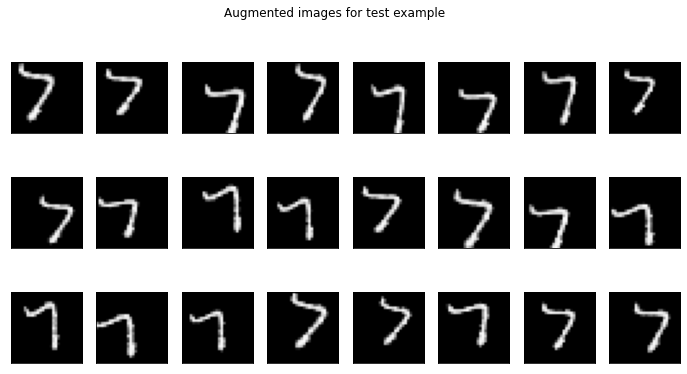

In [40]:
idx = 105
fig, axes = plt.subplots(3,8, figsize=(12,6)) 
x = np.array([X_train_xception[idx]])  # [[x1], [x2]] 
y = Y_train[idx].reshape(-1, 1)  # [[1], [3], ...]
fig.suptitle('Augmented images for test example') 
for i in range(3): 
    for j in range(8): 
        augmented_example_X, augmented_example_y = data_generator.flow( 
            x, y, batch_size=1).next() 
        axes[i,j].imshow(augmented_example_X.squeeze(), cmap='Greys') 
        axes[i,j].set_xticks([]) 
        axes[i,j].set_yticks([])

In [41]:
print(X_train_xception.shape)

train_generator = data_generator.flow( 
    X_train_xception,
    Y_train, 
    batch_size=32
)

(33600, 28, 28, 3)


In [42]:
r = train_generator.next()

(32,) (32, 28, 28, 3)


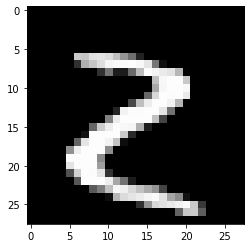

In [43]:
print(r[1].shape, r[0].shape)
plt.imshow(r[0][0])

In [44]:
steps_per_epoch = train_generator.n // train_generator.batch_size
steps_per_epoch

1050

### Train the model with data augmentation

In [45]:
Y_validation_subsample.reshape(-1, 1).shape

(5040, 1)

In [46]:
X_train_subsample_xception.shape, Y_train_subsample.shape

((20160, 28, 28, 3), (20160,))

In [48]:
print(Y_validation_subsample.reshape(-1, 1).shape)

history = xception.fit( 
    train_generator,
    validation_data=(
        X_validation_subsample_xception,
        Y_validation_subsample),
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=[
        EarlyStopping(monitor='val_loss', mode='min', patience=4),
        ModelCheckpoint('xception.h5')
    ]
)

(5040, 1)
Epoch 1/10
1050/1050 [==============================] - 105s 100ms/step - loss: 0.0685 - accuracy: 0.9834 - val_loss: 0.0374 - val_accuracy: 0.9903
Epoch 2/10
1050/1050 [==============================] - 105s 100ms/step - loss: 0.0652 - accuracy: 0.9840 - val_loss: 0.0496 - val_accuracy: 0.9895
Epoch 3/10
1050/1050 [==============================] - 104s 99ms/step - loss: 0.0645 - accuracy: 0.9842 - val_loss: 0.0317 - val_accuracy: 0.9935
Epoch 4/10
1050/1050 [==============================] - 105s 100ms/step - loss: 0.0536 - accuracy: 0.9871 - val_loss: 0.0338 - val_accuracy: 0.9917
Epoch 5/10
1050/1050 [==============================] - 104s 99ms/step - loss: 0.0584 - accuracy: 0.9863 - val_loss: 0.0569 - val_accuracy: 0.9879
Epoch 6/10
1050/1050 [==============================] - 104s 99ms/step - loss: 0.0462 - accuracy: 0.9881 - val_loss: 0.0243 - val_accuracy: 0.9952
Epoch 7/10
1050/1050 [==============================] - 105s 100ms/step - loss: 0.0433 - accuracy: 0.9896

### Train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

xception_history = xception.fit(
    X_train_xception,
    Y_train.reshape(-1, 1),
    validation_data=(
        X_validation_xception,
        Y_validation.reshape(-1, 1)
    ),
    epochs=5,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=4
        ),
        ModelCheckpoint('xception.h5')
    ]
)

Epoch 1/5
525/525 [==============================] - 91s 173ms/step - loss: 0.0298 - accuracy: 0.9930 - val_loss: 0.0992 - val_accuracy: 0.9767
Epoch 2/5
525/525 [==============================] - 92s 175ms/step - loss: 0.0324 - accuracy: 0.9925 - val_loss: 0.0406 - val_accuracy: 0.9904
Epoch 3/5
525/525 [==============================] - 91s 174ms/step - loss: 0.0219 - accuracy: 0.9949 - val_loss: 0.0297 - val_accuracy: 0.9926
Epoch 4/5
525/525 [==============================] - 91s 174ms/step - loss: 0.0193 - accuracy: 0.9955 - val_loss: 0.0389 - val_accuracy: 0.9919
Epoch 5/5
525/525 [==============================] - 91s 173ms/step - loss: 0.0184 - accuracy: 0.9955 - val_loss: 0.0413 - val_accuracy: 0.9923


NameError: ignored

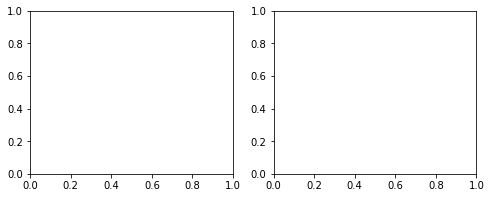

In [ ]:
plot_history(xception_history)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

xception_history = xception.fit(
    X_train_subsample_xception,
    Y_train_subsample.reshape(-1, 1),
    validation_data=(
        X_validation_subsample_xception,
        Y_validation_subsample.reshape(-1, 1)
    ),
    epochs=10,
    batch_size=64,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=10
        ),
        ModelCheckpoint('xception.h5')
    ]
)

Epoch 1/10
315/315 [==============================] - 57s 169ms/step - loss: 0.2467 - accuracy: 0.9358 - val_loss: 0.3598 - val_accuracy: 0.9683
Epoch 2/10
315/315 [==============================] - 53s 170ms/step - loss: 0.0862 - accuracy: 0.9806 - val_loss: 0.2596 - val_accuracy: 0.9516
Epoch 3/10
315/315 [==============================] - 54s 171ms/step - loss: 0.0597 - accuracy: 0.9860 - val_loss: 0.1013 - val_accuracy: 0.9859
Epoch 4/10
315/315 [==============================] - 57s 181ms/step - loss: 0.0586 - accuracy: 0.9866 - val_loss: 0.0702 - val_accuracy: 0.9865
Epoch 5/10
315/315 [==============================] - 55s 173ms/step - loss: 0.0470 - accuracy: 0.9893 - val_loss: 0.3037 - val_accuracy: 0.9613
Epoch 6/10
315/315 [==============================] - 55s 174ms/step - loss: 0.0400 - accuracy: 0.9909 - val_loss: 0.2063 - val_accuracy: 0.9768
Epoch 7/10
315/315 [==============================] - 55s 175ms/step - loss: 0.0445 - accuracy: 0.9903 - val_loss: 0.0606 - val_ac

KeyboardInterrupt: ignored

## Pretrained ResNet50 with data augmentation

### Preprocess the data

In [82]:
X_train, Y_train = get_X_Y(df_train)
X_validation, Y_validation = get_X_Y(df_validation)
X_test = df_test.values

res = get_subsample(0.3)
X_train_subsample, Y_train_subsample = res['train']
X_validation_subsample, Y_validation_subsample = res['validation']

report([X_train, X_validation, X_train_subsample, X_validation_subsample])
print_shapes([X_train, X_validation, X_train_subsample, X_validation_subsample])

255 0
255 0
255 0
255 0
(33600, 784)
(8400, 784)
(10080, 784)
(2520, 784)


In [83]:
X_train_resnet = prepare_resnet_data(X_train)
X_validation_resnet = prepare_resnet_data(X_validation)
X_train_subsample_resnet = prepare_resnet_data(X_train_subsample)
X_validation_subsample_resnet = prepare_resnet_data(X_validation_subsample)
X_test_resnet = prepare_resnet_data(X_test)

Init shape: (33600, 784)
Init shape: (33600, 28, 28)
151.061 -123.68
Result: ((33600, 28, 28, 3), None)

Init shape: (8400, 784)
Init shape: (8400, 28, 28)
151.061 -123.68
Result: ((8400, 28, 28, 3), None)

Init shape: (10080, 784)
Init shape: (10080, 28, 28)
151.061 -123.68
Result: ((10080, 28, 28, 3), None)

Init shape: (2520, 784)
Init shape: (2520, 28, 28)
151.061 -123.68
Result: ((2520, 28, 28, 3), None)

Init shape: (28000, 784)
Init shape: (28000, 28, 28)
151.061 -123.68
Result: ((28000, 28, 28, 3), None)



In [84]:
arrs = [
    X_train_resnet,
    X_validation_resnet,
    X_train_subsample_resnet,
    X_validation_subsample_resnet,
    X_test_resnet
]
print_shapes(arrs)
report(arrs)

(33600, 28, 28, 3)
(8400, 28, 28, 3)
(10080, 28, 28, 3)
(2520, 28, 28, 3)
(28000, 28, 28, 3)
151.061 -123.68
151.061 -123.68
151.061 -123.68
151.061 -123.68
151.061 -123.68


### Build the model

In [85]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    UpSampling2D,
    Dropout
)

resnet = Sequential()
resnet.add(Input(shape=(28, 28, 3)))
resnet.add(UpSampling2D(size=(8, 8)))
resnet.add(
    ResNet50(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(224, 224, 3)
    )
)
resnet.add(Dense(units=300, activation='relu', kernel_initializer='he_normal'))
resnet.add(Dropout(0.3))
resnet.add(Dense(units=300, activation='relu', kernel_initializer='he_normal'))
resnet.add(Dropout(0.3))
resnet.add(Dense(10, activation='softmax'))

In [86]:
resnet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Set data augmentation and train the model

In [87]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,  # 0.1,
    height_shift_range=0.1,  # 0.1,
    zoom_range=0.1,  # 0.1,
)

In [88]:
train_generator = data_generator.flow( 
    X_train_resnet,
    Y_train,
    batch_size=64
)
steps_per_epoch = train_generator.n // train_generator.batch_size
steps_per_epoch

525

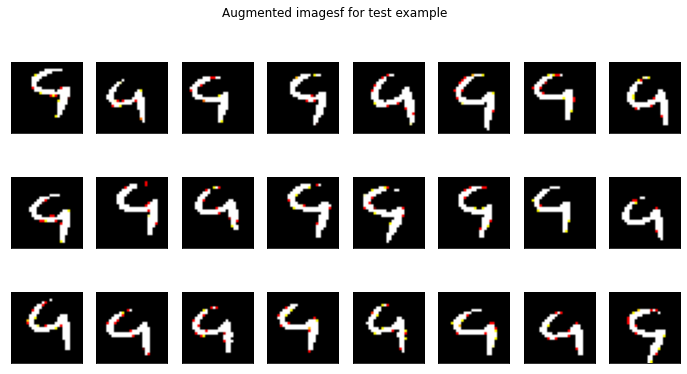

In [81]:
idx = 10 
fig, axes = plt.subplots(3,8, figsize=(12,6)) 
fig.suptitle('Augmented imagesf for test example') 
x = np.array([X_train_resnet[idx]])
y = Y_train[idx].reshape(-1, 1)# .reshape(-1, 10) 
for i in range(3): 
    for j in range(8): 
        augmented_example_X, augmented_example_y = data_generator.flow( 
            x, y, batch_size=1).next() 
        axes[i,j].imshow(augmented_example_X.squeeze(), cmap='Greys') 
        axes[i,j].set_xticks([]) 
        axes[i,j].set_yticks([])

In [89]:
train_subsample_generator = data_generator.flow( 
    X_train_subsample_resnet,
    Y_train_subsample,
    batch_size=64
)
steps_per_epoch_subsample = train_subsample_generator.n // train_subsample_generator.batch_size
steps_per_epoch_subsample

157

In [100]:
history = resnet.fit( 
    train_generator,
    validation_data=(X_validation_resnet, Y_validation),
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=4
        ),
        ModelCheckpoint('resnet_and_data_augmentation.h5')
    ]
)

Epoch 1/5
525/525 [==============================] - 382s 727ms/step - loss: 0.0269 - accuracy: 0.9934 - val_loss: 0.0266 - val_accuracy: 0.9939
Epoch 2/5
525/525 [==============================] - 381s 725ms/step - loss: 0.0234 - accuracy: 0.9936 - val_loss: 0.0231 - val_accuracy: 0.9940
Epoch 3/5
343/525 [==================>...........] - ETA: 2:03 - loss: 0.0270 - accuracy: 0.9925

KeyboardInterrupt: ignored

In [67]:
# history = resnet.fit( 
#     train_subsample_generator,
#     validation_data=(X_validation_subsample_resnet, Y_validation_subsample),
#     epochs=3,
#     batch_size=64,
#     callbacks=[
#         EarlyStopping(
#             monitor='val_loss',
#             mode='min',
#             patience=3
#         )
#     ]
# )

Epoch 1/3
 38/158 [======>.......................] - ETA: 1:22 - loss: 0.6991 - accuracy: 0.7862

KeyboardInterrupt: ignored

In [57]:
# history = resnet.fit(
#     X_train_subsample_resnet,
#     Y_train_subsample,
#     validation_data=(X_validation_subsample_resnet, Y_validation_subsample),
#     epochs=3,
#     batch_size=64,

# )

Epoch 1/3
 20/158 [==>...........................] - ETA: 1:31 - loss: 1.0093 - accuracy: 0.6633

KeyboardInterrupt: ignored

# Hyperparameters tuning

In [ ]:
!pip install keras_tuner

In [ ]:
import keras_tuner as kt
from functools import partial
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout
)
from tensorflow.keras import Model

ModuleNotFoundError: ignored

In [ ]:
def build_model(hyperparam):
    dropout_rate = hyperparam.Choice(
        'dropout_rate',
        [0.1, 0.2, 0.3, 0.4])
    final_dropout_rate = hyperparam.Choice(
        'final_dropout_rate',
        [0.3, 0.4, 0.5]
    )
    kernel_size = hyperparam.Choice(
        'kernel_size',
        [3, 5])
    n_conv_blocks = hyperparam.Choice(
        'n_conv_blocks',
        [2, 3, 4]
    )

    filter_combination = hyperparam.Choice(
        'filter_combination',
        [0, 1, 2, 3]
    )

    n_fully_connected_layers = hyperparam.Choice(
        'n_fully_connected_layers',
        [1, 2, 3])
    fc_units_choice = hyperparam.Choice(
        'fc_units_choice',
        [0, 1]
    )

    fc_comb_1 = [[100], [200]],
    fc_comb_2 = [[200, 100], [300, 200]]
    fc_comb_3 = [[500, 300, 100], [300, 200, 100], [150, 100, 50]]

    filter_combinations_two_layers = [
        [16, 32], [32, 64], [64, 128], [128, 256]
    ]
    filter_combinations_three_layers = [
        [16, 32, 48], [16, 32, 64], [32, 64, 128], [64, 128, 256]
    ]
    filter_combinations_four_layers = [
        [16, 16, 32, 32], [32, 32, 64, 64], [64, 64, 128, 128],
        [128, 128, 256, 256]
    ]

    if n_conv_blocks == 2:
        filter_combinations = filter_combinations_two_layers
    elif n_conv_blocks == 3:
        filter_combinations = filter_combinations_three_layers
    elif n_conv_blocks == 4:
        filter_combinations = filter_combinations_four_layers
    

    # Build the network
    conv_layer = partial(
        Conv2D,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        activation='relu'
    )

    input = Input(shape=(28, 28, 1))
    x = conv_layer(filters=filter_combinations[0])(input)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    for i in range(1, n_conv_blocks):
        x = conv_layer(filters=filter_combinations[i])(x),
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
    x = Flatten()(x)

    if n_fully_connected_layers == 1:
        units_combo = fc_comb_1[fc_units_choice]
    elif n_fully_connected_layers == 2:
        units_combo = fc_comb_2[fc_units_choice]
    elif n_fully_connected_layers == 3:
        units_combo = fc_comb_3[fc_units_choice]
    
    for i in range(len(units_combo)):
        x = Dense(units=units_combo[i], activation='relu')(x)
    x = Dropout(final_dropout_rate)(x)
    output = Dense(units=10, activation='softmax')(x)

    model = Model(inputs=input, outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model




# Submission

## For Xception

In [ ]:
test_predictions = xception.predict(X_test_xception)

875/875 [==============================] - 19s 20ms/step


In [ ]:
Y_test = np.argmax(test_predictions, axis=1)
Y_test

array([2, 0, 9, ..., 3, 9, 2])

In [ ]:
image_ids = list(range(1, X_test.shape[0] + 1))
labels = Y_test

In [ ]:
submission_df = pd.DataFrame(
    {
        'ImageId': image_ids,
        'Label': labels
    },
    index=None
)

submission_df = submission_df.set_index('ImageId')

In [ ]:
manager.save_to_csv(
    submission_df,
    manager.data_trial_path,
    'submission_xception.csv'
)

## For resnet

In [101]:
final_model = resnet

In [102]:
test_predictions = final_model.predict(X_test_resnet)

875/875 [==============================] - 85s 98ms/step


In [103]:
test_predictions.shape

(28000, 10)

In [104]:
Y_test = np.argmax(test_predictions, axis=1)

In [105]:
image_ids = list(range(1, X_test.shape[0] + 1))
labels = Y_test

In [106]:
submission_df = pd.DataFrame(
    {
        'ImageId': image_ids,
        'Label': labels
    },
    index=None
)

submission_df = submission_df.set_index('ImageId')

In [107]:
manager.save_to_csv(
    submission_df,
    manager.data_trial_path,
    'submission_resnet_and_data_augmentation.csv'
)

In [99]:
submission_df.Label.value_counts()

1    3187
7    2926
3    2811
2    2801
9    2793
6    2750
4    2748
0    2745
8    2745
5    2494
Name: Label, dtype: int64

## For rest of the models

In [ ]:
final_model = baseline_cnn  # ffnn_baseline

In [ ]:
# test_predictions = final_model.predict(X_test)
test_predictions = final_model.predict(X_test.reshape((X_test.shape[0], 28, 28)))

875/875 [==============================] - 34s 38ms/step


In [ ]:
Y_test = np.argmax(test_predictions, axis=1)

In [ ]:
image_ids = list(range(1, X_test.shape[0] + 1))
labels = Y_test

In [ ]:
submission_df = pd.DataFrame(
    {
        'ImageId': image_ids,
        'Label': labels
    },
    index=None
)

submission_df = submission_df.set_index('ImageId')

In [ ]:
manager.save_to_csv(
    submission_df,
    manager.data_trial_path,
    'submission.csv'
)